In [1]:
# Library imports.
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
import torchvision.datasets
sys.path.append('../')
plt.style.use('seaborn')

# Repository imports.
from FFBrainNet import FFBrainNet
from LocalNetBase import Options, UpdateScheme
from DataGenerator import random_halfspace_data
from train import *

## Methodology in this notebook: For every model, meta-learn on 4-dimensional halfspace, then train / test on 8-dimensional halfspace by transferring rules across networks.

In [2]:
def evaluate_simple(brain_up, brain_down, n_up, n_down):
    # Upstream.
    N = 1000
    X,y = random_halfspace_data(dim=n_up, n=3*N)
    X_test = X[:N]
    y_test = y[:N]
    X_train = X[N:]
    y_train = y[N:]

    print('Meta-learning...')
    data_up = metalearn_rules(
        X_train, y_train, brain_up, num_rule_epochs=20, num_epochs=2, batch_size=100, learn_rate=1e-2,
        X_test=X_test, y_test=y_test, verbose=False)
    
    # Transfer rules.
    try:
        brain_down.set_hidden_layer_rule(brain_up.get_hidden_layer_rule())
        brain_down.set_output_rule(brain_up.get_output_rule())
    except:
        brain_down.set_rnn_rule(brain_up.get_rnn_rule())
        brain_down.set_output_rule(brain_up.get_output_rule())
    
    # Downstream.
    N = 1000
    X, y = random_halfspace_data(dim=n_down, n=3*N)
    X_test = X[:N]
    y_test = y[:N]
    X_train = X[N:]
    y_train = y[N:]
    
    print('Training...')
    data_down = train_downstream(
        X_train, y_train, brain_down, num_epochs=5, batch_size=100, vanilla=False, learn_rate=1e-2,
        X_test=X_test, y_test=y_test, verbose=False, stats_interval=500)
    
    return (data_up, data_down)

In [3]:
def plot_curves(data_up, data_down):
    (meta_losses, meta_train_acc, meta_test_acc, meta_sample_counts, meta_stats) = data_up
    (plas_losses, plas_train_acc, plas_test_acc, plas_sample_counts, plas_stats) = data_down

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    ax[0].plot(meta_sample_counts, meta_losses, label='loss')
    ax[0].plot(meta_sample_counts, meta_train_acc, label='train')
    ax[0].plot(meta_sample_counts, meta_test_acc, label='test')
    ax[0].set_xlabel('Cumulative number of training samples')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Upstream meta-learning on 4-dim half-space')
    ax[0].legend()
    
    ax[1].plot(plas_sample_counts[1:], plas_losses[1:], label='loss')
    ax[1].plot(plas_sample_counts, plas_train_acc, label='train')
    ax[1].plot(plas_sample_counts, plas_test_acc, label='test')
    ax[1].set_xlabel('Cumulative number of training samples')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Downstream training on 8-dim half-space')
    ax[1].legend()
    
    plt.show()

In [4]:
def plot_compare_models(datas_up, datas_down, labels):
    num_models = len(datas_up)
    assert(num_models == len(datas_down) and num_models == len(labels))
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    for i in range(num_models):
        ax[0].plot(datas_up[i][3], datas_up[i][2], label=labels[i])
        ax[1].plot(datas_down[i][3], datas_down[i][2], label=labels[i])
        
    ax[0].set_xlabel('Cumulative number of training samples')
    ax[0].set_ylabel('Test accuracy')
    ax[0].set_title('Upstream meta-learning on 4-dim half-space')
    ax[0].legend()
    ax[1].set_xlabel('Cumulative number of training samples')
    ax[1].set_ylabel('Test accuracy')
    ax[1].set_title('Downstream training on 8-dim half-space')
    ax[1].legend()
    plt.show()

## First, test original RNN as sanity check.

In [5]:
# IMPORTANT: Henceforth, we use GD directly on inputs but use plasticity rules in the output and hidden layers.
opts_up = Options(gd_input=True,
                  use_graph_rule=True,
                  gd_graph_rule=True,
                  use_output_rule=True,
                  gd_output_rule=True,
                  gd_output=False)
opts_down = Options(gd_input=True,
                    use_graph_rule=True,
                    gd_graph_rule=False,  # Not meta-trainable anymore!
                    use_output_rule=True,
                    gd_output_rule=False,  # Not meta-trainable anymore!
                    gd_output=False)
scheme = UpdateScheme(cross_entropy_loss=True,
                      mse_loss=False,
                      update_misclassified_only=False,
                      update_all_edges=True)
n_up = 4  # Input layer size for meta-learning.
n_down = 8  # Input layer size for desired task training.
m = 2  # Output layer size.
l = 2  # Number of hidden layers.
w = 10  # Width of hidden layers.
p = 0.5  # Connectivity probability.
cap = 5  # Number of nodes firing per layer.

In [6]:
from network import *
brain_rnn_up = LocalNet(n_up, m, 100, p, 50, 3, options=opts_up, update_scheme=scheme)
brain_rnn_down = LocalNet(n_down, m, 100, p, 50, 3, options=opts_down, update_scheme=scheme)

  0%|                  | 0/20 [00:00<?, ?it/s]

==== Original RNN (very different from all the rest) ====
Meta-learning...


100%|█████████| 20/20 [01:19<00:00,  3.96s/it]
..\LocalNetBase.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.rnn_rule = torch.tensor(rule).flatten().double()
  4%|▏     | 73/2000 [00:00<00:02, 722.12it/s]

Last loss: 0.7076
Last train accuracy: 0.5165
Last test accuracy: 0.5250
Training...
INITIAL train accuracy: 0.4680
INITIAL test accuracy: 0.4910
Epoch 1 / 5 ...


  3%|▏     | 67/2000 [00:00<00:02, 666.03it/s]


Epoch 2 / 5 ...


  7%|▎    | 144/2000 [00:00<00:02, 685.03it/s]


Epoch 3 / 5 ...


  4%|▏     | 74/2000 [00:00<00:02, 739.33it/s]


Epoch 4 / 5 ...


  8%|▍    | 151/2000 [00:00<00:02, 752.28it/s]


Epoch 5 / 5 ...


100%|████| 2000/2000 [00:02<00:00, 682.63it/s]



Last loss: 0.7773
Last train accuracy: 0.4965
Last test accuracy: 0.4670


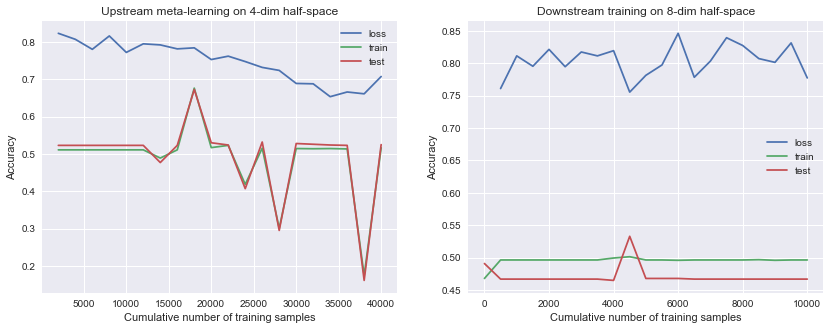

In [7]:
print('==== Original RNN (very different from all the rest) ====')
data_rnn = evaluate_simple(brain_rnn_up, brain_rnn_down, n_up, n_down)
plot_curves(*data_rnn)

## Then, test all table-based feed-forward networks by Brett.

In [8]:
from FFLocalTableRules.FFLocalTable_PrePost import FFLocalTable_PrePost
from FFLocalTableRules.FFLocalTable_PrePostCount import FFLocalTable_PrePostCount
from FFLocalTableRules.FFLocalTable_PrePostPercent import FFLocalTable_PrePostPercent
from FFLocalTableRules.FFLocalTable_PostCount import FFLocalTable_PostCount

In [9]:
# Initialize models.
brain_prepost_up = FFLocalTable_PrePost(n_up, m, l, w, p, cap, options=opts_up, update_scheme=scheme)
brain_prepost_down = FFLocalTable_PrePost(n_down, m, l, w, p, cap, options=opts_down, update_scheme=scheme)
brain_prepostcount_up = FFLocalTable_PrePostCount(n_up, m, l, w, p, cap, options=opts_up, update_scheme=scheme)
brain_prepostcount_down = FFLocalTable_PrePostCount(n_down, m, l, w, p, cap, options=opts_down, update_scheme=scheme)
brain_prepostpercent_up = FFLocalTable_PrePostPercent(n_up, m, l, w, p, cap, options=opts_up, update_scheme=scheme)
brain_prepostpercent_down = FFLocalTable_PrePostPercent(n_down, m, l, w, p, cap, options=opts_down, update_scheme=scheme)
brain_postcount_up = FFLocalTable_PostCount(n_up, m, l, w, p, cap, options=opts_up, update_scheme=scheme)
brain_postcount_down = FFLocalTable_PostCount(n_down, m, l, w, p, cap, options=opts_down, update_scheme=scheme)

  0%|                  | 0/20 [00:00<?, ?it/s]

==== Interpretation: Pre and Post ====
Meta-learning...


100%|█████████| 20/20 [00:38<00:00,  1.94s/it]
..\FFLocalTableRules\FFLocalTableNet.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.hidden_layer_rule = torch.tensor(rule).flatten().double()
  7%|▎   | 144/2000 [00:00<00:01, 1438.70it/s]

Last loss: 0.3892
Last train accuracy: 0.9510
Last test accuracy: 0.9550
Training...
INITIAL train accuracy: 0.5485
INITIAL test accuracy: 0.5620
Epoch 1 / 5 ...


 14%|▌   | 289/2000 [00:00<00:01, 1419.92it/s]


Epoch 2 / 5 ...


 14%|▌   | 279/2000 [00:00<00:01, 1374.55it/s]


Epoch 3 / 5 ...


 15%|▌   | 293/2000 [00:00<00:01, 1448.98it/s]


Epoch 4 / 5 ...


  7%|▎   | 138/2000 [00:00<00:01, 1378.74it/s]


Epoch 5 / 5 ...


100%|███| 2000/2000 [00:01<00:00, 1346.23it/s]



Last loss: 0.7324
Last train accuracy: 0.5870
Last test accuracy: 0.5870


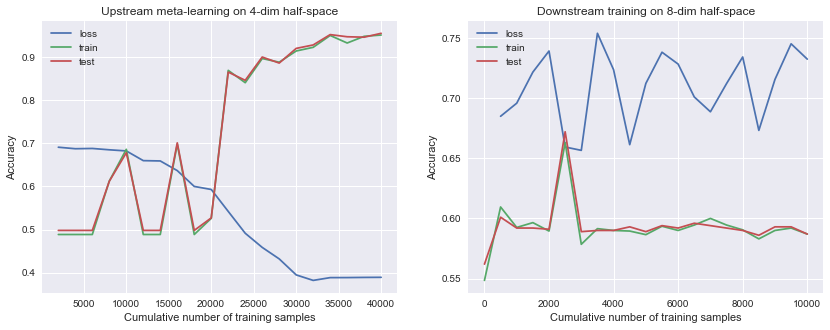

  0%|                  | 0/20 [00:00<?, ?it/s]

==== Interpretation: Pre and Post and Incoming Count ====
Meta-learning...


100%|█████████| 20/20 [00:43<00:00,  2.18s/it]
..\FFLocalTableRules\FFLocalTableNet.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.hidden_layer_rule = torch.tensor(rule).flatten().double()
  7%|▎   | 143/2000 [00:00<00:01, 1421.53it/s]

Last loss: 0.6931
Last train accuracy: 0.5080
Last test accuracy: 0.5180
Training...
INITIAL train accuracy: 0.4490
INITIAL test accuracy: 0.4100
Epoch 1 / 5 ...


  6%|▎   | 129/2000 [00:00<00:01, 1288.83it/s]


Epoch 2 / 5 ...


  7%|▎   | 138/2000 [00:00<00:01, 1378.69it/s]


Epoch 3 / 5 ...


 14%|▌   | 279/2000 [00:00<00:01, 1387.57it/s]


Epoch 4 / 5 ...


  7%|▎   | 143/2000 [00:00<00:01, 1428.70it/s]


Epoch 5 / 5 ...


100%|███| 2000/2000 [00:01<00:00, 1254.91it/s]



Last loss: 0.6931
Last train accuracy: 0.4810
Last test accuracy: 0.4890


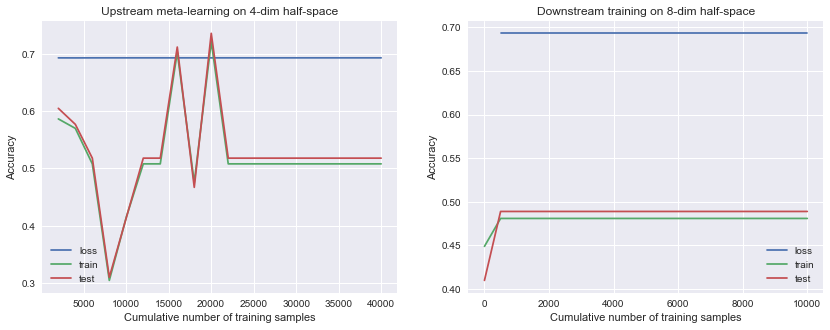

  0%|                  | 0/20 [00:00<?, ?it/s]

==== Interpretation: Pre and Post and Binned Incoming Fraction ====
Meta-learning...


100%|█████████| 20/20 [00:48<00:00,  2.41s/it]
..\FFLocalTableRules\FFLocalTableNet.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.hidden_layer_rule = torch.tensor(rule).flatten().double()
  6%|▏   | 124/2000 [00:00<00:01, 1238.87it/s]

Last loss: 0.3813
Last train accuracy: 0.9440
Last test accuracy: 0.9440
Training...
INITIAL train accuracy: 0.5185
INITIAL test accuracy: 0.4940
Epoch 1 / 5 ...


 13%|▌   | 255/2000 [00:00<00:01, 1271.82it/s]


Epoch 2 / 5 ...


 12%|▍   | 232/2000 [00:00<00:01, 1130.74it/s]


Epoch 3 / 5 ...


 12%|▍   | 249/2000 [00:00<00:01, 1229.06it/s]


Epoch 4 / 5 ...


 13%|▌   | 255/2000 [00:00<00:01, 1275.81it/s]


Epoch 5 / 5 ...


100%|███| 2000/2000 [00:01<00:00, 1163.94it/s]



Last loss: 0.6398
Last train accuracy: 0.6220
Last test accuracy: 0.6220


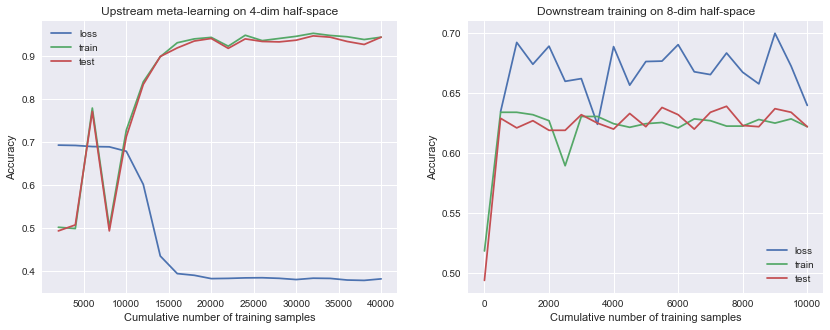

  0%|                  | 0/20 [00:00<?, ?it/s]

==== Interpretation: Post and Incoming Count ====
Meta-learning...


100%|█████████| 20/20 [00:41<00:00,  2.06s/it]
..\FFLocalTableRules\FFLocalTableNet.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.hidden_layer_rule = torch.tensor(rule).flatten().double()
  7%|▎   | 145/2000 [00:00<00:01, 1448.68it/s]

Last loss: 0.6931
Last train accuracy: 0.5055
Last test accuracy: 0.4960
Training...
INITIAL train accuracy: 0.5670
INITIAL test accuracy: 0.5510
Epoch 1 / 5 ...


  7%|▎   | 134/2000 [00:00<00:01, 1338.79it/s]


Epoch 2 / 5 ...


 14%|▌   | 284/2000 [00:00<00:01, 1437.45it/s]


Epoch 3 / 5 ...


 14%|▌   | 281/2000 [00:00<00:01, 1373.16it/s]


Epoch 4 / 5 ...


  7%|▎   | 148/2000 [00:00<00:01, 1478.65it/s]


Epoch 5 / 5 ...


100%|███| 2000/2000 [00:01<00:00, 1314.99it/s]



Last loss: 0.6931
Last train accuracy: 0.5145
Last test accuracy: 0.4840


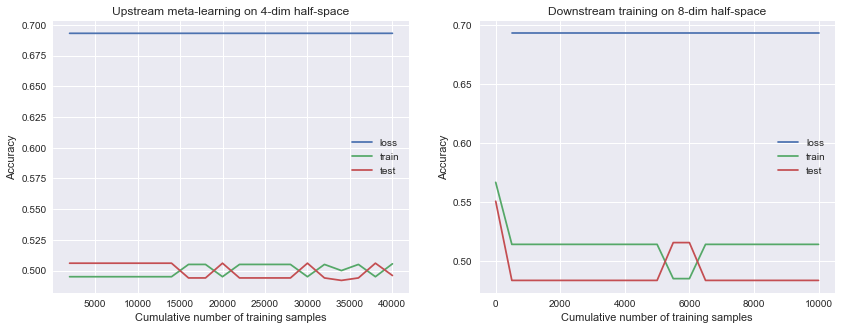

In [10]:
# Evaluate models.
print('==== Interpretation: Pre and Post ====')
data_prepost = evaluate_simple(brain_prepost_up, brain_prepost_down, n_up, n_down)
plot_curves(*data_prepost)
print('==== Interpretation: Pre and Post and Incoming Count ====')
data_prepostcount = evaluate_simple(brain_prepostcount_up, brain_prepostcount_down, n_up, n_down)
plot_curves(*data_prepostcount)
print('==== Interpretation: Pre and Post and Binned Incoming Fraction ====')
data_prepostpercent = evaluate_simple(brain_prepostpercent_up, brain_prepostpercent_down, n_up, n_down)
plot_curves(*data_prepostpercent)
print('==== Interpretation: Post and Incoming Count ====')
data_postcount = evaluate_simple(brain_postcount_up, brain_postcount_down, n_up, n_down)
plot_curves(*data_postcount)

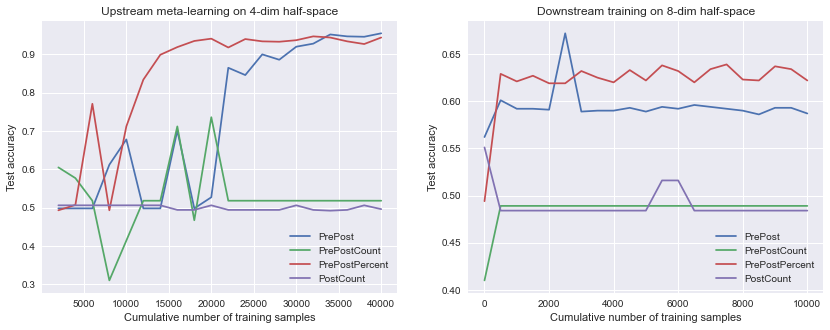

In [11]:
datas = [data_rnn, data_prepost, data_prepostcount, data_prepostpercent, data_postcount]
labels = ['RNN', 'PrePost', 'PrePostCount', 'PrePostPercent', 'PostCount']
plot_compare_models([x[0] for x in datas], [x[1] for x in datas], labels)